# Noise Schedules for Diffusion-based Generative Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import load_dataset
from diffusers import DDPMScheduler
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Resize,
    ToTensor,
)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "mathtext.fontset": "cm",
    "font.size": 14
})

## Choose time discretization

In [2]:
T = 1000

In [3]:
t = torch.arange(1, T + 1)

## Define different noise schedules

In [4]:
constant = torch.pow(torch.tensor(0.01), t / T)

In [5]:
linear = torch.cumprod(0.9999 - 0.0199 * t / T, dim=0)

In [6]:
hyperbolic = torch.cumprod(1 / (1 + 1 / (T - t)), dim=0)

In [7]:
s = 0.008
f = lambda t: torch.cos(torch.pi/2 * (t / T + s) / (1 + s)) ** 2
cos_squared = f(t) / f(torch.tensor(0))

In [8]:
schedules = {
    "constant": constant,
    "linear": linear,
    "hyperbolic": hyperbolic,
    "cos_squared": cos_squared 
}

## Plot remaining signal over time for all noise schedules

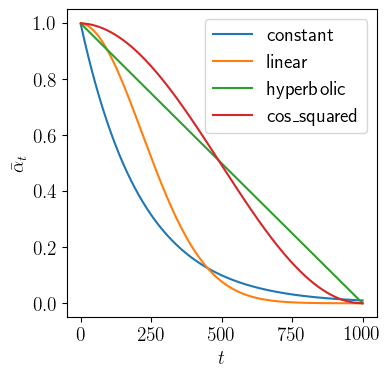

In [9]:
plt.figure(figsize=(4, 4))
for label, cumalphas in schedules.items():
    plt.plot(t, cumalphas, label=label)
plt.xlabel("$t$")
plt.ylabel("$\\bar{\\alpha}_t$")
plt.legend()
plt.savefig("schedules.pdf", bbox_inches="tight")

## Plot image evolution over time for all noise schedules

In [10]:
def noisify(sample, cumalphas):
    cumalphas_prev = cumalphas.roll(shifts=1)
    cumalphas_prev[0] = 1
    betas = 1 - cumalphas / cumalphas_prev
    scheduler = DDPMScheduler(num_train_timesteps=T, trained_betas=betas)
    
    sample = sample.unsqueeze(0)
    noise = torch.randn(image.shape).unsqueeze(0)
    timesteps = torch.cat(((torch.arange(8) * T / 8).round().long(), torch.tensor([T - 1])))
    
    return scheduler.add_noise(sample, noise, timesteps)

In [11]:
dataset = load_dataset("nelorth/oxford-flowers", split="test")
preprocessing = Compose([Resize(64), CenterCrop(64), ToTensor()])
dataset.set_transform(lambda batch: {"input": [preprocessing(image.convert("RGB")) for image in batch["image"]]})
image = dataset[5]["input"]

noisies = [torch.cat(noisify(image, cumalphas).unbind(), dim=2) for cumalphas in schedules.values()]

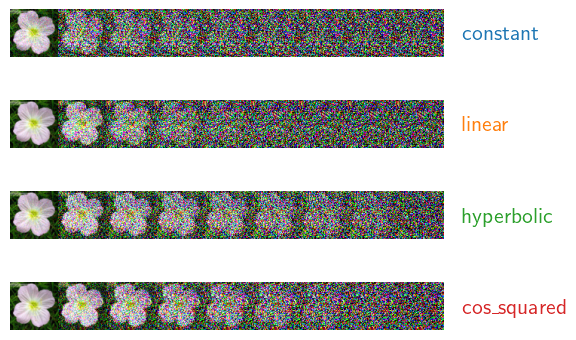

In [12]:
plt.figure(figsize=(6, 4))
colorcycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for i in range(len(schedules)):
    plt.subplot(4, 1, i + 1)
    plt.imshow(noisies[i].permute(1, 2, 0))
    plt.text(600, 40, list(schedules.keys())[i], color=colorcycle[i], fontsize=16)
    plt.axis("off")
plt.tight_layout()
plt.savefig("noisies.pdf")